In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

print(tf.__version__)

2.10.0


2700/2700 [==============================] - 3s 956us/step


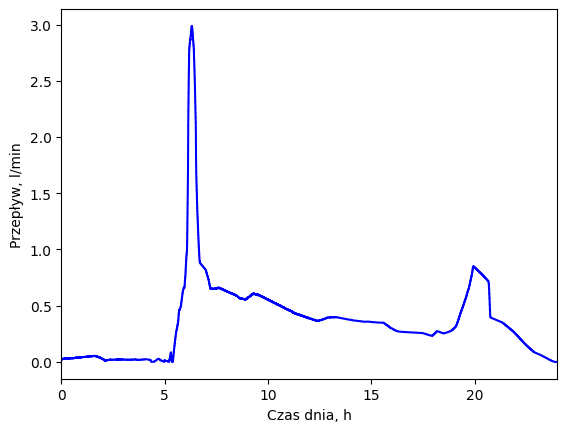

In [33]:
model= tf.keras.models.load_model("../Modele/11_12_testowanie/model_calosc_z_dodatku")
flow_time=np.arange(0,1,1/1440/60) 
flow_time_plot=np.arange(0,24,24/1440/60) 

test=0.9 #0.2 0.4 0.5 0.9gut 
model_input=np.vstack((2*np.ones_like(flow_time, dtype=int), 2*np.ones_like(flow_time, dtype=int), flow_time, test*np.ones_like(flow_time, dtype=int))).T

model_result=model.predict(model_input)
model_result=np.clip(model_result, a_min=0, a_max=None)
plt.plot(flow_time_plot, model_result,color='blue')

plt.xlabel('Czas dnia, h')
plt.ylabel('Przepływ, l/min')
plt.xlim(0, 24)

F_in=model_result

F_in=F_in/40


In [38]:
T_set=50                         # temperatura zadana
delta_t=0                        # czułość regulatora
temp_in=10                       # temperatura wody wejściowej
TEMP_OUT=25.5                      # temperatura zewnętrzna

B_1_2   =0.00001                      # współczyniki wymiany ciepła miedzy 1 a 2 warstwą
B_1_IN  =0.71                      # współczyniki wymiany ciepła miedzy 1 a 0 warstwą
B_1_OUT =0.00006                     # współczyniki wymiany ciepła miedzy 1 a otoczeniem
B_1_2_d =0.0001

B_2_3   =0.0001                     # współczyniki wymiany ciepła miedzy 2 a 3 warstwą
B_2_1_d =0.065                      # współczyniki wymiany ciepła miedzy 2 a 1 warstwą
B_2_1   =0.00079
B_2_OUT =0.0019                    # współczyniki wymiany ciepła miedzy 2 a otoczeniem
B_2_HEAT=0.02                     # współczyniki wymiany ciepła miedzy 2 a grzałką

B_3_OUT =0.0053                     # współczyniki wymiany ciepła miedzy 3 a otoczeniem
B_3_HEAT=0.03                      # współczyniki wymiany ciepła miedzy 3 a grzałką
B_3_2_d =0.0067
B_3_2   =0.0054


MOC_PIECA=9000/60                  # moc pieca

P_piec  =0.17                     # współczyniki działania pieca
P_OUT   =0.0048                     # współczyniki wymiany ciepła miedzy piecem a otoczeniem
P_3     =0.014                     # współczyniki wymiany ciepła miedzy piecem a 3
F_Z     =0.5/60    

TWO_1_SET=temp_in                # temepratura początkowa wody w 1 warstwie
TWO_2_SET=T_set      # temepratura początkowa wody w 2 warstwie
TWO_3_SET=(temp_in+T_set)/2                  # temepratura początkowa wody w 3 warstwie
TZI_SET=T_set                       # temepratura początkowa wody w piecu warstwie


Two_1 = np.array([TWO_1_SET])
Two_2 = np.array([TWO_2_SET])
Two_3 = np.array([TWO_3_SET])
Tzi = np.array([TZI_SET])
piec_ster = np.array([1])

In [39]:
for i in range(0, len(flow_time_plot)-1):
    Two_1=np.append(Two_1,Two_1[i]+
                     -B_1_IN * F_in[i] * (Two_1[i] - temp_in)         # 1 - 0
                     -B_1_OUT * (Two_1[i] - TEMP_OUT)                 # 1 - OT
                     +(B_1_2+B_1_2_d*F_in[i]) * (Two_2[i] - Two_1[i])                   # 1 - 2
                     )               

    Two_2=np.append(Two_2,Two_2[i]+
                    -(B_2_1+B_2_1_d*F_in[i]) * (Two_2[i] - Two_1[i])          # 1 - 2
                     -B_2_OUT * (Two_2[i] - TEMP_OUT)                 # 2 - OT
                     +B_2_3 * (Two_3[i] - Two_2[i])                   # 2 - 3 
                     +B_2_HEAT * F_Z * (Tzi[i] - Two_2[i])            # 2 - piec
                     )                 

    Two_3=np.append(Two_3,Two_3[i]+
                     -B_3_OUT * (Two_3[i] - TEMP_OUT)                 # 3 - OT
                     -(B_3_2+B_3_2_d*F_in[i]) * (Two_3[i] - Two_2[i])                   # 3 - 2
                     +B_3_HEAT * F_Z * (Tzi[i] - Two_3[i])            # 3 - piec
                     ) 
    
    Tzi=np.append(Tzi,Tzi[i]+
                  piec_ster[i] * P_piec * MOC_PIECA                   # Piec
                  -P_3 * F_Z * (Tzi[i] - Two_3[i])                    # piec - 3
                  -P_OUT * (Tzi[i] - TEMP_OUT)                        # piec - OT
                  )

    if(piec_ster[i] == 1 and Two_2[i] > (T_set + delta_t)):
        piec_ster=np.append(piec_ster,0)
    elif (piec_ster[i] == 0 and Two_2[i] < (T_set - delta_t)):
        piec_ster=np.append(piec_ster,1)
    else:
        piec_ster=np.append(piec_ster,piec_ster[i])

Text(0.5, 0, 'Czas, h')

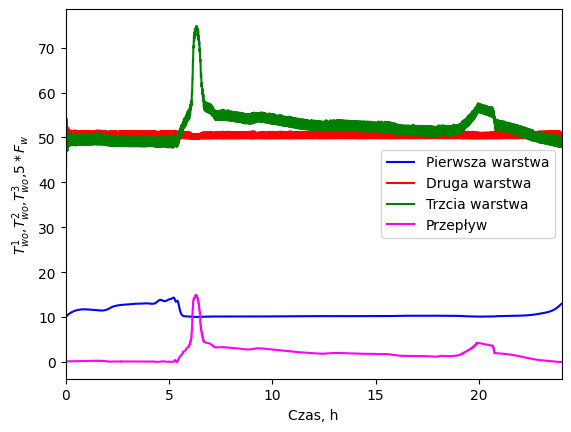

In [40]:
plt.plot(flow_time_plot, Two_1,color='blue', label='Pierwsza warstwa')
plt.plot(flow_time_plot, Two_2,color='red', label='Druga warstwa')
plt.plot(flow_time_plot, Two_3,color='green', label='Trzcia warstwa')
plt.plot(flow_time_plot, 5*model_result,color='magenta', label='Przepływ')
plt.xlim(0,24)
plt.legend(loc='center right')
plt.ylabel('$T_{wo}^1$,$T_{wo}^2$,$T_{wo}^3$,$5*F_w$')
plt.xlabel('Czas, h')

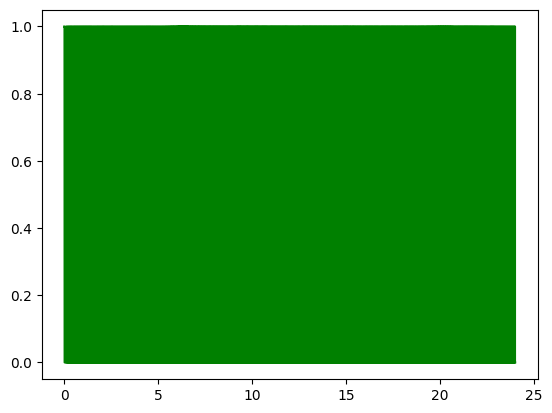

In [41]:
plt.plot(flow_time_plot, piec_ster,color='green')

## OPTYMALIZACJA

In [42]:
G=np.trapz(piec_ster*P_piec*MOC_PIECA)
G

274571.25000000006

In [8]:
sign = (np.sign(Two_3 - T_set - delta_t) + np.sign(Two_3 - T_set + delta_t)) / 2
temp_diff = (Two_3 - T_set) ** 2
J = np.trapz(temp_diff * np.abs(sign))
J

10032961.546948077

## 2D

In [9]:
T_set_wybrane = np.arange(T_set-10, T_set+11) # od 40 do 60
G_all=np.array([])
J_all=np.array([])

for t_set in T_set_wybrane:
        Two_1 = np.array([TWO_1_SET])
        Two_2 = np.array([TWO_2_SET])
        Two_3 = np.array([TWO_3_SET])
        Tzi = np.array([TZI_SET])
        piec_ster = np.array([1])
    
        for i in range(0, len(flow_time_plot)-1):
            Two_1=np.append(Two_1,Two_1[i]+
                             -B_1_IN * F_in[i] * (Two_1[i] - temp_in)         # 1 - 0
                             -B_1_OUT * (Two_1[i] - TEMP_OUT)                 # 1 - OT
                             +(B_1_2+B_1_2_d*F_in[i]) * (Two_2[i] - Two_1[i])                   # 1 - 2
                             )               
        
            Two_2=np.append(Two_2,Two_2[i]+
                            -(B_2_1+B_2_1_d*F_in[i]) * (Two_2[i] - Two_1[i])          # 1 - 2
                             -B_2_OUT * (Two_2[i] - TEMP_OUT)                 # 2 - OT
                             +B_2_3 * (Two_3[i] - Two_2[i])                   # 2 - 3 
                             +B_2_HEAT * F_Z * (Tzi[i] - Two_2[i])            # 2 - piec
                             )                 
        
            Two_3=np.append(Two_3,Two_3[i]+
                             -B_3_OUT * (Two_3[i] - TEMP_OUT)                 # 3 - OT
                             -(B_3_2+B_3_2_d*F_in[i]) * (Two_3[i] - Two_2[i])                   # 3 - 2
                             +B_3_HEAT * F_Z * (Tzi[i] - Two_3[i])            # 3 - piec
                             ) 
            
            Tzi=np.append(Tzi,Tzi[i]+
                          piec_ster[i] * P_piec * MOC_PIECA                   # Piec
                          -P_3 * F_Z * (Tzi[i] - Two_3[i])                    # piec - 3
                          -P_OUT * (Tzi[i] - TEMP_OUT)                        # piec - OT
                          )
        
            if(piec_ster[i] == 1 and Two_2[i] > (t_set + delta_t)):
                piec_ster=np.append(piec_ster,0)
            elif (piec_ster[i] == 0 and Two_2[i] < (t_set - delta_t)):
                piec_ster=np.append(piec_ster,1)
            else:
                piec_ster=np.append(piec_ster,piec_ster[i])
    
        G=np.trapz(piec_ster*P_piec*MOC_PIECA)
        G_all=np.append(G_all,G)

        sign = (np.sign(Two_3 - t_set - delta_t) + np.sign(Two_3 - t_set + delta_t)) / 2
        temp_diff = (Two_3 - t_set) ** 2
        J = np.trapz(temp_diff * np.abs(sign))
        J_all=np.append(J_all,J)


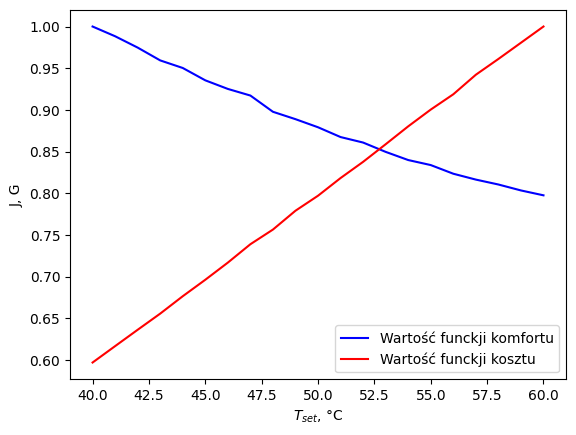

In [10]:
J_all_norm=J_all/J_all.max()
G_all_norm=G_all/G_all.max()

plt.plot(T_set_wybrane, J_all_norm,color='blue', label='Wartość funckji komfortu')
plt.plot(T_set_wybrane, G_all_norm,color='red', label='Wartość funckji kosztu')
plt.ylabel('J, G')
plt.xlabel('$T_{set}$, \u00b0C')
plt.legend()

## 3D

In [11]:
T_set_wybrane = np.arange(T_set-10, T_set+11) # od 40 do 60
delta_wybrane = np.arange(delta_t-2, delta_t+2.5,0.5)   # od 2 do 6
G_all=np.array([])
J_all=np.array([])
t_set_plot=np.array([])
delta_set_plot=np.array([])

safety=0;
for delta_set in delta_wybrane:
    for t_set in T_set_wybrane:
        Two_1 = np.array([TWO_1_SET])
        Two_2 = np.array([TWO_2_SET])
        Two_3 = np.array([TWO_3_SET])
        Tzi = np.array([TZI_SET])
        piec_ster = np.array([1])
    
        for i in range(0, len(flow_time_plot)-1):
            Two_1=np.append(Two_1,Two_1[i]+
                             -B_1_IN * F_in[i] * (Two_1[i] - temp_in)         # 1 - 0
                             -B_1_OUT * (Two_1[i] - TEMP_OUT)                 # 1 - OT
                             +(B_1_2+B_1_2_d*F_in[i]) * (Two_2[i] - Two_1[i])                   # 1 - 2
                             )               

            Two_2=np.append(Two_2,Two_2[i]+
                            -(B_2_1+B_2_1_d*F_in[i]) * (Two_2[i] - Two_1[i])          # 1 - 2
                             -B_2_OUT * (Two_2[i] - TEMP_OUT)                 # 2 - OT
                             +B_2_3 * (Two_3[i] - Two_2[i])                   # 2 - 3 
                             +B_2_HEAT * F_Z * (Tzi[i] - Two_2[i])            # 2 - piec
                             )                 

            Two_3=np.append(Two_3,Two_3[i]+
                             -B_3_OUT * (Two_3[i] - TEMP_OUT)                 # 3 - OT
                             -(B_3_2+B_3_2_d*F_in[i]) * (Two_3[i] - Two_2[i])                   # 3 - 2
                             +B_3_HEAT * F_Z * (Tzi[i] - Two_3[i])            # 3 - piec
                             ) 
            
            Tzi=np.append(Tzi,Tzi[i]+
                          piec_ster[i] * P_piec * MOC_PIECA                   # Piec
                          -P_3 * F_Z * (Tzi[i] - Two_3[i])                    # piec - 3
                          -P_OUT * (Tzi[i] - TEMP_OUT)                        # piec - OT
                          )

            if(piec_ster[i] == 1 and Two_2[i] > (t_set + delta_set)):
                piec_ster=np.append(piec_ster,0)
            elif (piec_ster[i] == 0 and Two_2[i] < (t_set - delta_set)):
                piec_ster=np.append(piec_ster,1)
            else:
                piec_ster=np.append(piec_ster,piec_ster[i])
    
        G=np.trapz(piec_ster*P_piec*MOC_PIECA)
        G_all=np.append(G_all,G)

        sign = (np.sign(Two_3 - t_set - delta_set) + np.sign(Two_3 - t_set + delta_set)) / 2
        temp_diff = (Two_3 - t_set) ** 2
        J = np.trapz(temp_diff * np.abs(sign))
        J_all=np.append(J_all,J)
        
        t_set_plot=np.append(t_set_plot,t_set)
        delta_set_plot=np.append(delta_set_plot,delta_set)
        safety=safety+1
        print(safety)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189


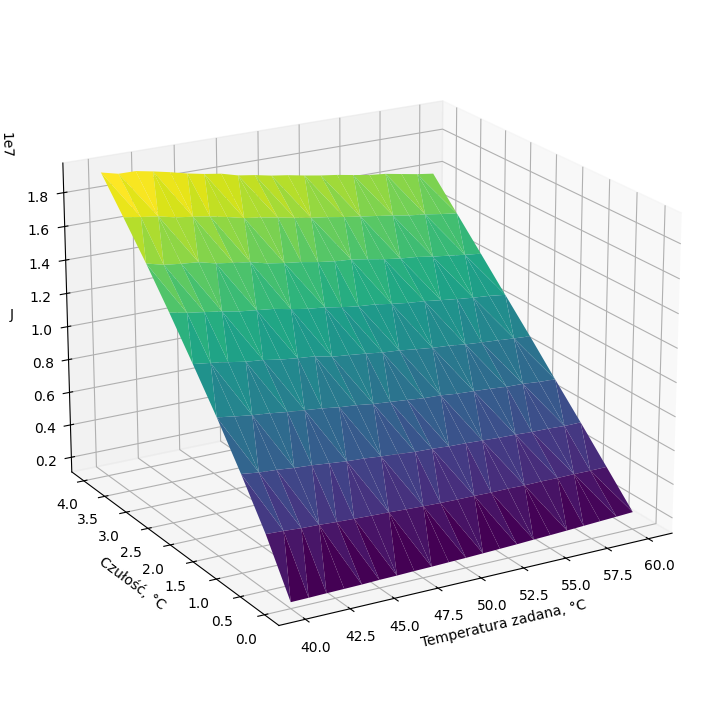

In [32]:
T_set, Delta_set = np.meshgrid(t_set_plot, delta_set_plot)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')


ax.plot_trisurf(t_set_plot, delta_set_plot, J_all, cmap='viridis')


ax.set_xlabel('Temperatura zadana, \u00b0C')
ax.set_ylabel('Czułość, \u00b0C')
ax.set_zlabel('J')

# ax.w_xaxis.set_rotate_label(False)
# ax.w_yaxis.set_rotate_label(False)
# ax.w_zaxis.set_rotate_label(False)

# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10,location='left')

ax.view_init(elev=20, azim=240) 

plt.show()

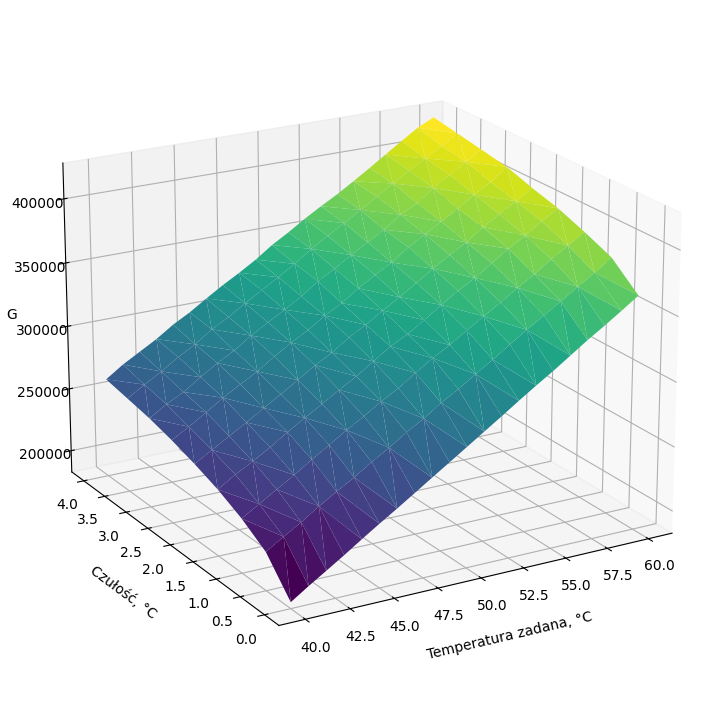

In [13]:
T_set, Delta_set = np.meshgrid(t_set_plot, delta_set_plot)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')


ax.plot_trisurf(t_set_plot, delta_set_plot, G_all, cmap='viridis')


ax.set_xlabel('Temperatura zadana, \u00b0C', labelpad=10)
ax.set_ylabel('Czułość, \u00b0C', labelpad=10)
ax.set_zlabel('G')

# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10,location='left')

ax.view_init(elev=20, azim=240) 

plt.show()